# Kuvantunnistus omista kuvista
Tunnistetaan kuvia aterimista

In [11]:
# Importit
from keras.utils import to_categorical, image_dataset_from_directory
import pandas as pd
from keras import layers
from keras import models
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)

## Malli 1: Oman CNN mallin koulutus ja testaus:

### Aluksi rajataan kuvat omiin kansioihinsa
- 70% treenidataan
- 15% validointiin
- 15% lopulliseen testidataan

In [12]:
# Define paths
input_folder = 'OriginalPhotos'  # Source folder containing images
output_folder = 'DatasetSplit'  # Destination folder for train/val/test split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Delete existing output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Ensure output folders exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to copy files while maintaining folder structure
def split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio):
    for root, dirs, files in os.walk(input_folder):
        if not files:  # Skip directories without files
            continue

        # Get relative path to preserve folder structure
        relative_path = os.path.relpath(root, input_folder)

        # Create corresponding subfolders in train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_folder, split, relative_path), exist_ok=True)

        # Shuffle files to randomize the split
        random.shuffle(files)

        # Calculate split indices
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split files into train, val, and test
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Adjust for rounding issues to ensure val and test are equal
        while len(val_files) > len(test_files):
            test_files.append(val_files.pop())
        while len(test_files) > len(val_files):
            val_files.append(test_files.pop())

        # Copy files to respective folders
        for file in train_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'train', relative_path, file))
        for file in val_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'val', relative_path, file))
        for file in test_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'test', relative_path, file))

# Call the function
split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio)

print(f"Images have been split into train, validation, and test folders in '{output_folder}'")

Images have been split into train, validation, and test folders in 'DatasetSplit'


### Tuodaan ja valmistellaan kuvat
- Luokitellaan kuvat
- Laitetaan kuvat datasettiin

Kuvien luokittelut tulee automaattisesti kerasin image_dataset_from_directory -funktiolla.
Funktio tekee suurimman osan vaikeasta työstä.

In [13]:
imgSize = 224
imgPath = 'OriginalPhotos'
batchSize = 8

# Kopioi kuvat testi, train ja val kansioihin
# Testiin menee 20% kuvista, ja 80% menee train kansioon
# Jaetaan data 80/20 train/val


# Haetaan kuvat kansiosta ja luodaan DataFrame
train_dataset = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

val_dataset = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

test_dataset = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

classNames = train_dataset.class_names
print('Class names: ', classNames)
classesAmount = len(train_dataset.class_names)


# Rescaling layer
rescale = layers.Rescaling(1./255)

Found 173 files belonging to 3 classes.
Found 39 files belonging to 3 classes.
Found 37 files belonging to 3 classes.
Class names:  ['Haarukat', 'Lusikat', 'Veitset']


#### Testataan augmentaatiota kuville

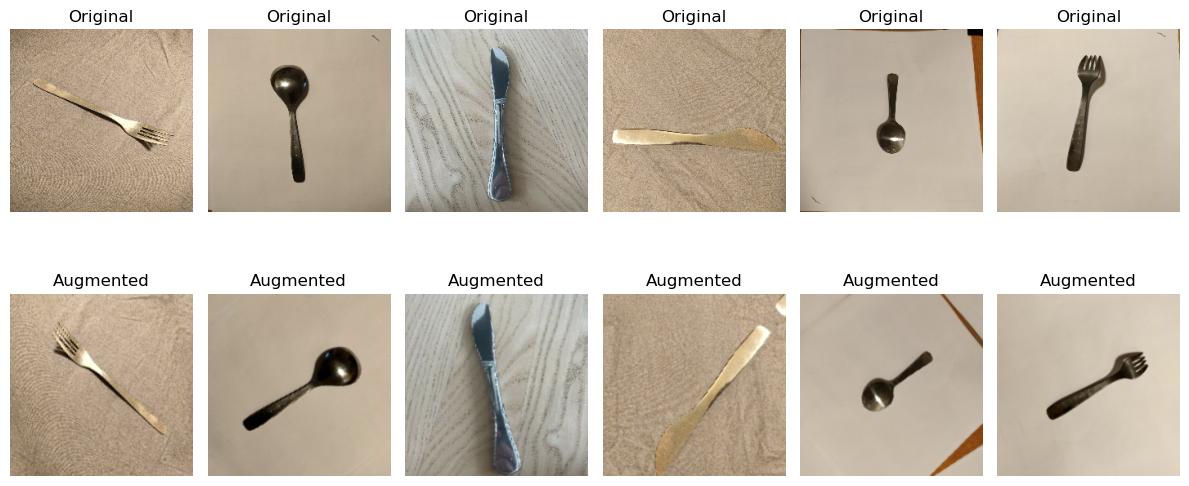

In [14]:
# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


# DEBUGATAAN AUGMENTAATIOTA ---------------------
# Select a batch of images from the training dataset
for images, labels in train_dataset.take(1):  # Take one batch
    break

# Apply data augmentation to the batch
augmented_images = data_augmentation(images)

# Plot the original and augmented images
plt.figure(figsize=(12, 6))

for i in range(6):  # Display 6 images
    # Original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 6, i + 7)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()
# -----------------------------------------------
# DEBUGATAAN AUGMENTAATIOTA ---------------------

### Testi dataset eläinkuville, poistetaan lopuksi

In [15]:
# Kuvat ja Dataset eläimille

# Kansiot
input_folder = 'dogs-vs-cats_small'
output_folder = 'AnimalsDatasetSplit'

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Delete existing output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Ensure output folders exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to copy files while maintaining folder structure

split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio)
print(f"Images have been split into train, validation, and test folders in '{output_folder}'")


# Laitetaan Datasettiin
imgSize = 224
imgPath = 'OriginalPhotos'
batchSize = 8

# Kopioi kuvat testi, train ja val kansioihin
# Testiin menee 20% kuvista, ja 80% menee train kansioon
# Jaetaan data 80/20 train/val


# Haetaan kuvat kansiosta ja luodaan DataFrame
animal_train_dataset = image_dataset_from_directory(
    directory=output_folder + '/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

animal_val_dataset = image_dataset_from_directory(
    directory=output_folder + '/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

animal_test_dataset = image_dataset_from_directory(
    directory=output_folder + '/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
)

classNames = animal_train_dataset.class_names
print('Class names: ', classNames)
classesAmount = len(classNames)

Images have been split into train, validation, and test folders in 'AnimalsDatasetSplit'
Found 3500 files belonging to 3 classes.
Found 750 files belonging to 3 classes.
Found 750 files belonging to 3 classes.
Class names:  ['test', 'train', 'validation']


#### Treenaus eläinkuvilla

In [17]:
# DEBUG TREENAUS ELÄIMILLE ---------------------
# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

l2Reg = regularizers.l2(0.002)


# Mallin kerrokset
model = models.Sequential([
    layers.Input(shape=(imgSize, imgSize, 3)),
    layers.Rescaling(1./255),

    #data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Dropout(1/3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(1/3),

    layers.Dense(classesAmount, activation='softmax')  # Output layer
])


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam()

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    animal_train_dataset,
    validation_data=animal_val_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,855 (45.64 MB)

 Trainable params: 11,963,721 (45.64 MB)

 Non-trainable params: 134 (536.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.3786 - loss: 9.2376 - val_accuracy: 0.2667 - val_loss: 31.6139
Epoch 2/50
324/438 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.4006 - loss: 1.0685

KeyboardInterrupt: 

### Treenaus

Luodaan malli ja muut.

Mallissa on augmentaatiokerros ja kaksi konvoluutiokerrosta. Ensin pienempi konvoluutiokerros löytää pienemmät yksityiskohdat, ja sitten suurempi konvoluutiokerros löytää suuremmat kuvassa olevat muodot. Lopuksi kuva litistetään ja annetaan Dense layerille ennen eri luokkiin painotusta.

Käytetään säädettäviä early-stopping ja optimizer muuttujia hienosäätöä varten.

In [5]:
l2Reg = regularizers.l2(0.002)

# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Mallin kerrokset
model = models.Sequential([
    layers.Input(shape=(imgSize, imgSize, 3)),

    data_augmentation,

    layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(1/3),

    layers.Dense(classesAmount, activation='softmax')  # Output layer
])


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam()

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    verbose=1,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])


'''# DEBUGAUS -------------------------------------------------------------
predictions = model.predict(val_dataset)
print(np.argmax(predictions, axis=1))  # Predicted classes

for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    print("Predictions (probabilities):", predictions[:5])
    print("True labels:", labels.numpy()[:5])
print("Predicted classes:", np.argmax(predictions, axis=1)[:5])
print("True classes:", np.argmax(labels.numpy(), axis=1)[:5])
# DEBUGAUS -------------------------------------------------------------'''


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             

 Total params: 125,651 (490.82 KB)

 Trainable params: 125,091 (488.64 KB)

 Non-trainable params: 560 (2.19 KB)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.3759 - loss: 2.1156 - val_accuracy: 0.2778 - val_loss: 2.0900
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.4798 - loss: 2.0526 - val_accuracy: 0.3611 - val_loss: 1.8542
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.5494 - loss: 1.7056 - val_accuracy: 0.3889 - val_loss: 2.0438
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.4271 - loss: 1.8824 - val_accuracy: 0.2778 - val_loss: 1.9225
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.4651 - loss: 1.9079 - val_accuracy: 0.3333 - val_loss: 1.9083
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5285 - loss: 1.6988 - val_accuracy: 0.3333 - val_loss: 1.8648
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.4069 - loss: 1.7750 - val_accuracy: 0.4167 - val_loss: 1.7852
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5669 - loss: 1.5858 - val_accu

'# DEBUGAUS -------------------------------------------------------------\npredictions = model.predict(val_dataset)\nprint(np.argmax(predictions, axis=1))  # Predicted classes\n\nfor images, labels in val_dataset.take(1):\n    predictions = model.predict(images)\n    print("Predictions (probabilities):", predictions[:5])\n    print("True labels:", labels.numpy()[:5])\nprint("Predicted classes:", np.argmax(predictions, axis=1)[:5])\nprint("True classes:", np.argmax(labels.numpy(), axis=1)[:5])\n# DEBUGAUS -------------------------------------------------------------'

##### Piirretään:

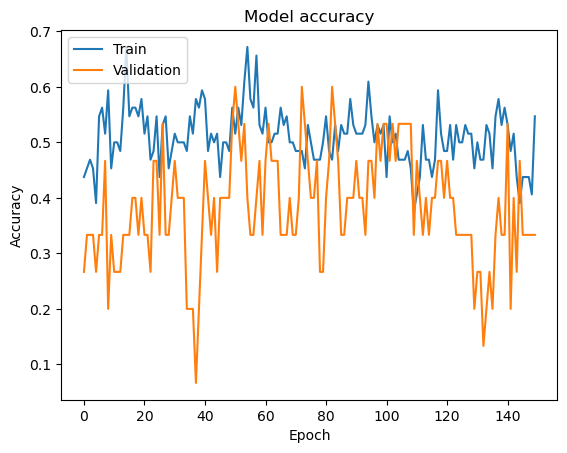

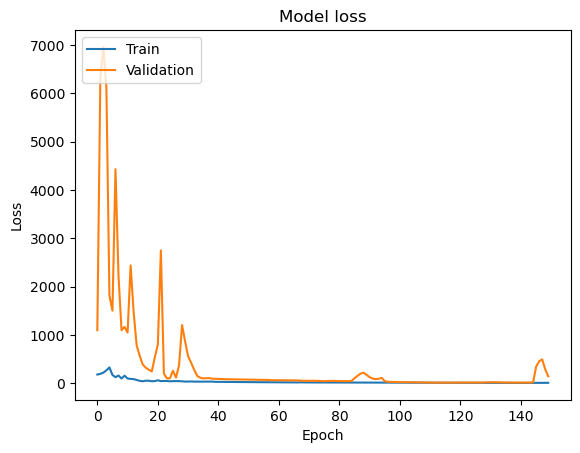

In [14]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Oman mallin analysointi:
Malli ei oikein suoriudu. Loss laskee epochien aikana, mutta accuracy harhailee holtittomasti.


## Malli 2: Esikoulutettu malli

In [ ]:
from keras.applications import VGG16

# Set the image size to match VGG16 input requirements
imgSize_vgg = 224
batchSize_vgg = 8

# Annetaan VGG16 mallille samat datasetit, kuin edelliselle mallille
train_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)


Found 64 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 13 files belonging to 3 classes.


c:\Users\Administrator\VSCode projects\Neuroverkot\.conda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


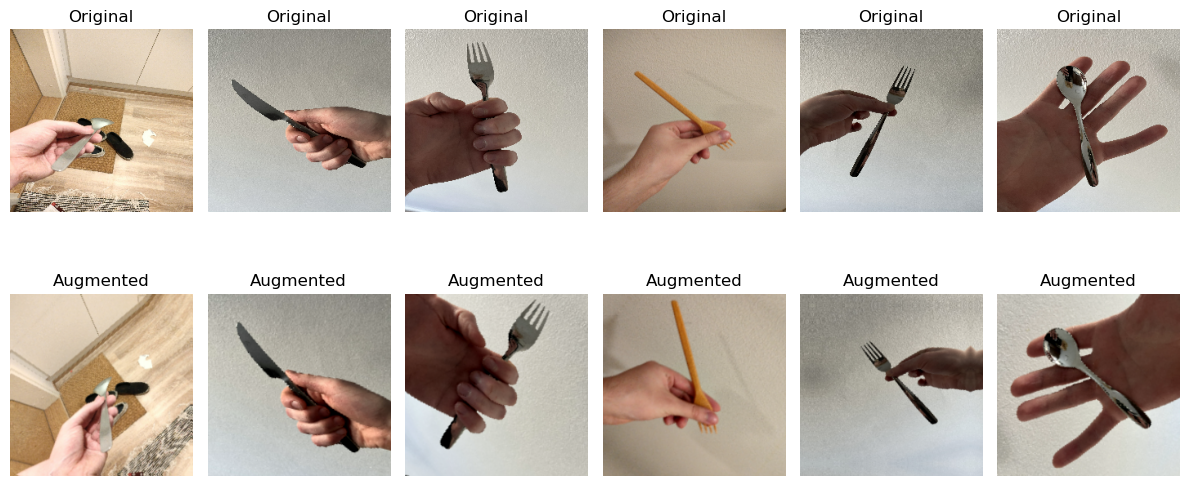

In [ ]:
# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


# DEBUGATAAN AUGMENTAATIOTA ---------------------
# Select a batch of images from the training dataset
for images, labels in train_dataset_vgg.take(1):  # Take one batch
    break

# Apply data augmentation to the batch
augmented_images = data_augmentation(images)

# Plot the original and augmented images
plt.figure(figsize=(12, 6))

for i in range(6):  # Display 6 images
    # Original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 6, i + 7)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()
# -----------------------------------------------
# DEBUGATAAN AUGMENTAATIOTA ---------------------

In [ ]:

# Load pre-trained VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(imgSize_vgg, imgSize_vgg, 3))

# Freeze the convolutional base to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
vgg_model = models.Sequential([
    base_model, # Aiemmin otettu VGG16 malli
    # VGG mallin jälkeen lisätään omat kerrokset:
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(0.4),
    layers.Dense(classesAmount, activation='softmax')
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.001)

vgg_model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

vgg_history = vgg_model.fit(
    train_dataset_vgg,
    validation_data=val_dataset_vgg,
    epochs=150,
    verbose=0,
    callbacks=[early_stopping]
)

print("Training complete!")
print("Accuracy: ", vgg_history.history['accuracy'][-1])
print("Validation Accuracy: ", vgg_history.history['val_accuracy'][-1])
print("Loss: ", vgg_history.history['loss'][-1])
print("Validation Loss: ", vgg_history.history['val_loss'][-1])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,579 (62.26 MB)

 Trainable params: 1,605,891 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training complete!
Accuracy:  0.921875
Validation Accuracy:  0.800000011920929
Loss:  1.0679595470428467
Validation Loss:  2.730092763900757


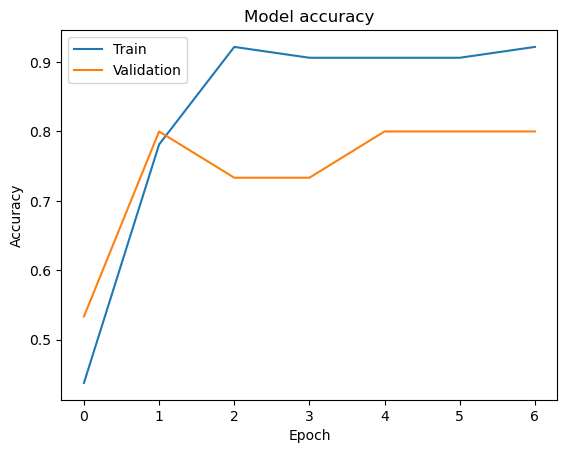

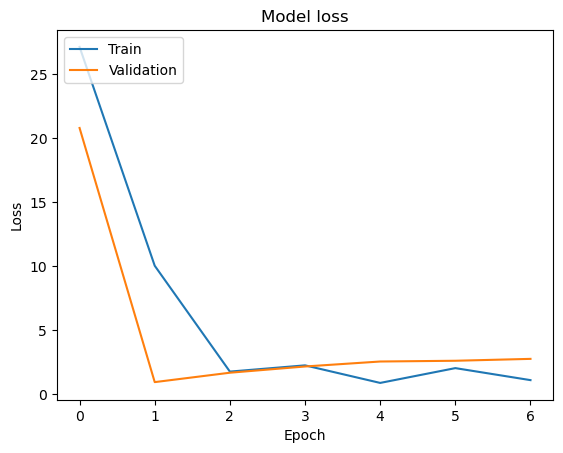

In [ ]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Vaihe 3: RAPORTTI ja Analysointi:

Itse koulutettu malli suorituituu paljon huonommin, kuin esikoulutettu VGG16 -malli.

Itse koulutetun mallin validation accuracy pyörii 0.3 ympäristössä, mikä viittaa siihen, että se luokittelee kuvat lähestulkoon satunnaisesti.


Aluksi ongelmana oli se, että kuvat standardisoitiin kahteen kertaan, joka teki niistä mustia, koska kuvien väridata jaettiin kahteen kertaan 1/255. Tämän korjattua tarkkuus ei kuitenkaan parantunut merkittävästi.